处理图像 C:\Users\28489\Desktop\paired\31\1.jpg
处理图像 C:\Users\28489\Desktop\paired\31\2.jpg
处理图像 C:\Users\28489\Desktop\paired\31\4.jpg
处理图像 C:\Users\28489\Desktop\paired\31\5.jpg
处理图像 C:\Users\28489\Desktop\paired\31\6.jpg


Fitting a model with 104 free scalar parameters with only 40 data points will result in a degenerate solution.


RL优化迭代 1/10


Fitting a model with 104 free scalar parameters with only 40 data points will result in a degenerate solution.


当前迭代得分: 0.4226
发现更好的解决方案，得分: 0.4226
RL优化迭代 2/10


Fitting a model with 104 free scalar parameters with only 40 data points will result in a degenerate solution.


当前迭代得分: 0.4511
发现更好的解决方案，得分: 0.4511
RL优化迭代 3/10


Fitting a model with 104 free scalar parameters with only 40 data points will result in a degenerate solution.


当前迭代得分: 0.4511
RL优化迭代 4/10


Fitting a model with 104 free scalar parameters with only 40 data points will result in a degenerate solution.


当前迭代得分: 0.4511
RL优化迭代 5/10


Fitting a model with 104 free scalar parameters with only 40 data points will result in a degenerate solution.


当前迭代得分: 0.4511
RL优化迭代 6/10


Fitting a model with 104 free scalar parameters with only 40 data points will result in a degenerate solution.


当前迭代得分: 0.4511
RL优化迭代 7/10


Fitting a model with 104 free scalar parameters with only 40 data points will result in a degenerate solution.


当前迭代得分: 0.4511
RL优化迭代 8/10


Fitting a model with 104 free scalar parameters with only 40 data points will result in a degenerate solution.


当前迭代得分: 0.4511
RL优化迭代 9/10


Fitting a model with 104 free scalar parameters with only 40 data points will result in a degenerate solution.


当前迭代得分: 0.4511
RL优化迭代 10/10
当前迭代得分: 0.4511
优化完成，最终得分: 0.4511
构建的图包含 5 个节点和 0 条边


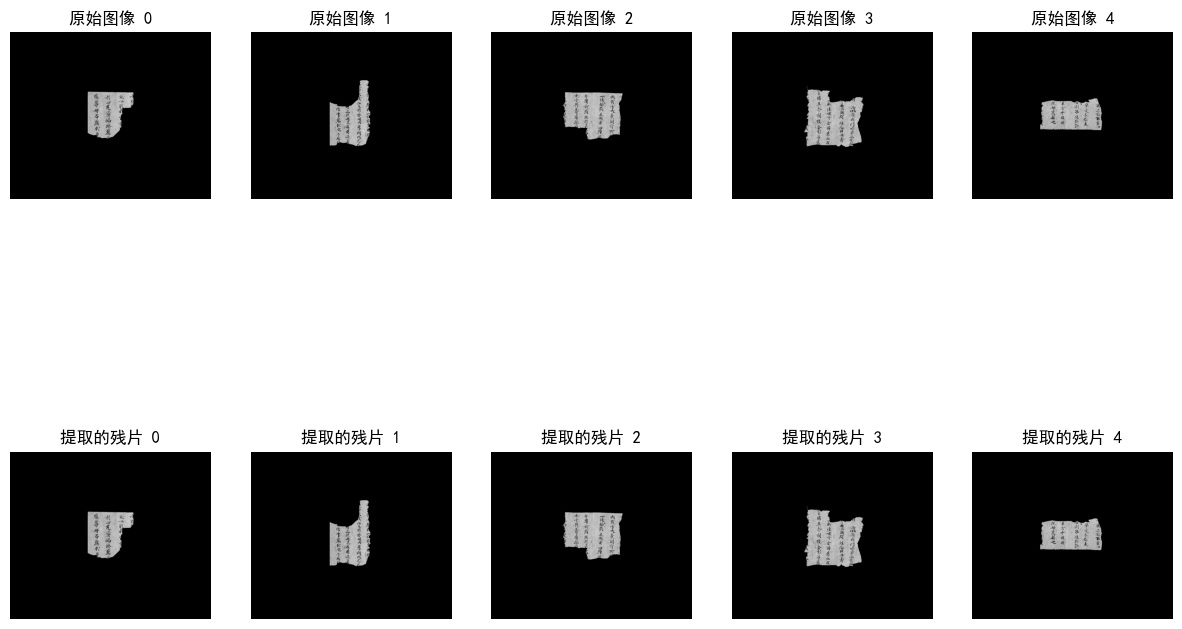

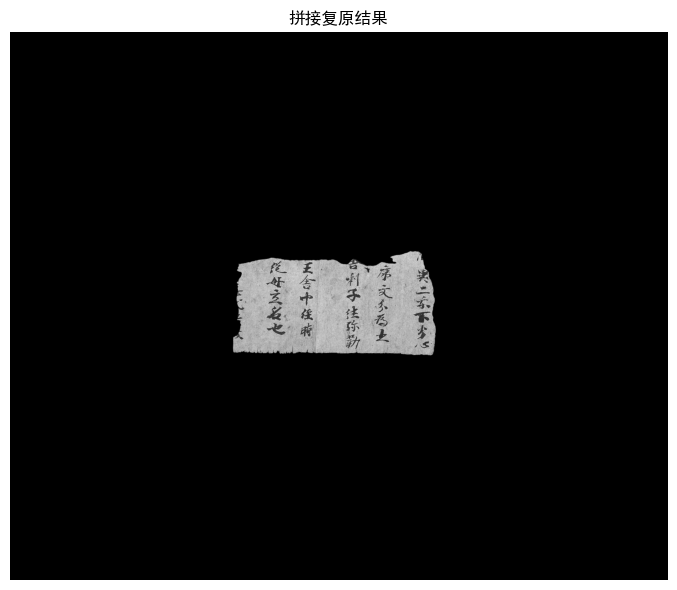

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Tuple, Union
import torch
from transformers import BertModel, BertTokenizer
from hmmlearn import hmm
from scipy.spatial.distance import cdist
from scipy.special import softmax

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# GraphNode, GraphEdge, Graph, ContourProcessor 类保持不变

class GraphNode:
    def __init__(
        self,
        node_id: int,
        freeman_codes: Dict[str, List[int]],
        centroid: Tuple[float, float],
        contour_centroids: List[Tuple[float, float]],
        semantic_vector: Optional[np.ndarray] = None,
        contours: Optional[List[np.ndarray]] = None,
        image_id: Optional[int] = None,
        original_image: Optional[np.ndarray] = None
    ):
        self.id = node_id
        self.freeman_codes = freeman_codes
        self.centroid = centroid
        self.contour_centroids = contour_centroids
        self.semantic_vector = semantic_vector
        self.contours = contours
        self.image_id = image_id
        self.original_image = original_image
        
    def __repr__(self):
        return f"GraphNode(id={self.id}, image_id={self.image_id}, centroid={self.centroid})"

class GraphEdge:
    def __init__(self, node1: int, node2: int, weight: Optional[float] = None):
        self.node1 = node1
        self.node2 = node2
        self.weight = weight
        
    def __repr__(self):
        return f"GraphEdge({self.node1} <-> {self.node2}, weight={self.weight})"

class Graph:
    def __init__(self):
        self.nodes: Dict[int, GraphNode] = {}
        self.edges: List[GraphEdge] = []
        self._next_node_id = 0
        
    def add_node(self, freeman_codes, centroid, contour_centroids, text=None, bert_model=None, bert_tokenizer=None, contours=None, image_id=None, original_image=None):
        semantic_vector = None
        if text and bert_model and bert_tokenizer:
            semantic_vector = self._generate_bert_vector(text, bert_model, bert_tokenizer)
        
        node_id = self._next_node_id
        self.nodes[node_id] = GraphNode(
            node_id=node_id,
            freeman_codes=freeman_codes,
            centroid=centroid,
            contour_centroids=contour_centroids,
            semantic_vector=semantic_vector,
            contours=contours,
            image_id=image_id,
            original_image=original_image
        )
        self._next_node_id += 1
        return node_id
    
    def add_edge(self, node1: int, node2: int, weight: Optional[float] = None):
        if node1 not in self.nodes or node2 not in self.nodes:
            raise ValueError("One or both nodes do not exist in the graph")
        self.edges.append(GraphEdge(node1, node2, weight))
    
    def _generate_bert_vector(self, text, bert_model, bert_tokenizer):
        inputs = bert_tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        return outputs.last_hidden_state[:, 0, :].numpy()
    
    def visualize(self, stitched_image: Optional[np.ndarray] = None):
        plt.figure(figsize=(15, 10))
        
        unique_image_ids = set(node.image_id for node in self.nodes.values())
        for idx, img_id in enumerate(unique_image_ids, 1):
            node = next(n for n in self.nodes.values() if n.image_id == img_id)
            original_img = node.original_image
            
            mask = np.zeros_like(original_img)
            cv2.drawContours(mask, [np.vstack(node.contours)], -1, (255), thickness=cv2.FILLED)
            fragment = cv2.bitwise_and(original_img, original_img, mask=mask)
            
            plt.subplot(2, len(unique_image_ids), idx)
            plt.imshow(original_img, cmap='gray')
            plt.title(f'原始图像 {img_id}')
            plt.axis('off')
            
            plt.subplot(2, len(unique_image_ids), idx + len(unique_image_ids))
            plt.imshow(fragment, cmap='gray')
            plt.title(f'提取的残片 {img_id}')
            plt.axis('off')
        
        if stitched_image is not None:
            plt.figure(figsize=(10, 6))
            plt.imshow(stitched_image, cmap='gray')
            plt.title('拼接复原结果')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()

class ContourProcessor:
    def process_image(self, image_path: str) -> Tuple[List[np.ndarray], List[List[int]]]:
        """处理图像并提取轮廓"""
        try:
            original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if original is None:
                raise ValueError(f"无法读取图像: {image_path}")

            processed = self.preprocess(original)
            if processed is None:
                raise ValueError("图像预处理失败")
            
            contours, hierarchy = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            if not contours:
                raise ValueError("未找到任何轮廓")
            
            valid_contours = [cnt for cnt in contours if self.is_valid_contour(cnt, original.shape)]
            if not valid_contours:
                raise ValueError("未找到有效轮廓，请调整预处理参数")

            best_contour = max(valid_contours, key=lambda c: cv2.contourArea(c))
            perimeter = cv2.arcLength(best_contour, True)
            epsilon = 0.01 * perimeter
            approx = cv2.approxPolyDP(best_contour, epsilon, True)

            for _ in range(20):
                if len(approx) == 4:
                    break
                elif len(approx) > 4:
                    epsilon *= 1.1
                else:
                    epsilon *= 0.9
                approx = cv2.approxPolyDP(best_contour, epsilon, True)
            
            if len(approx) != 4:
                raise ValueError("无法近似为恰好4个点")

            contour_points = best_contour.reshape(-1, 2)
            indices = [np.argmin(np.sum((contour_points - p)**2, axis=1)) 
                      for p in approx.reshape(-1, 2)]
            indices.sort()

            if len(set(indices)) != 4:
                raise ValueError("近似点映射到重复索引")

            segments = [
                best_contour[indices[0]:indices[1]+1],
                best_contour[indices[1]:indices[2]+1],
                best_contour[indices[2]:indices[3]+1],
                np.vstack((best_contour[indices[3]:], best_contour[:indices[0]+1]))
            ]

            chain_codes = [self.freeman_chain_code(seg, closed=False) for seg in segments]
            
            if len(segments) != 4 or len(chain_codes) != 4:
                raise ValueError("轮廓分割或链码生成失败")
            
            return segments, chain_codes

        except Exception as e:
            print(f"图像处理错误: {str(e)}")
            raise

    def preprocess(self, img):
        if img is None:
            return None
            
        blurred = cv2.GaussianBlur(img, (7, 7), 1.5)
        thresh = cv2.adaptiveThreshold(
            blurred, 
            255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY_INV, 
            21, 
            6
        )
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
        return closed

    def is_valid_contour(self, cnt, img_shape):
        area = cv2.contourArea(cnt)
        if area < 500:
            return False
        
        x, y, w, h = cv2.boundingRect(cnt)
        if (x == 0 or y == 0 or 
            x + w >= img_shape[1] - 1 or 
            y + h >= img_shape[0] - 1):
            return False
        
        solidity = area / (w * h)
        return 0.3 < solidity < 0.9

    def freeman_chain_code(self, contour, closed=True):
        directions = [0, 1, 2, 3, 4, 5, 6, 7]
        dx = [1, 1, 0, -1, -1, -1, 0, 1]
        dy = [0, 1, 1, 1, 0, -1, -1, -1]
        chain_code = []
        n = len(contour)
        
        for i in range(n - 1 if not closed else n):
            current = contour[i % n][0]
            next_p = contour[(i + 1) % n][0]
            delta = (next_p[0] - current[0], next_p[1] - current[1])
            
            for j, (ddx, ddy) in enumerate(zip(dx, dy)):
                if delta == (ddx, ddy):
                    chain_code.append(j)
                    break
            else:
                raise ValueError(f"Invalid direction delta: {delta} at index {i}")
        
        return chain_code

    def compute_shape_context(self, contour, n_points=100, n_bins_r=5, n_bins_theta=12):
        contour = contour.squeeze()
        sampled_points = np.array([
            contour[int(i * len(contour) / n_points)] 
            for i in range(n_points)
        ])
        
        shape_contexts = []
        for i in range(n_points):
            diff = sampled_points - sampled_points[i]
            distances = np.sqrt(np.sum(diff**2, axis=1))
            angles = np.arctan2(diff[:, 1], diff[:, 0])
            
            angles[angles < 0] += 2 * np.pi
            
            max_dist = distances.max()
            min_dist = distances[distances > 0].min()
            log_r_bins = np.logspace(np.log10(min_dist), np.log10(max_dist), n_bins_r)
            theta_bins = np.linspace(0, 2*np.pi, n_bins_theta+1)
            
            hist, _, _ = np.histogram2d(
                distances, angles, 
                bins=[log_r_bins, theta_bins]
            )
            shape_contexts.append(hist.flatten())
            
        return np.array(shape_contexts)

    def dtw_distance(self, seq1, seq2):
        n, m = len(seq1), len(seq2)
        dtw_matrix = np.inf * np.ones((n + 1, m + 1))
        dtw_matrix[0, 0] = 0
        
        for i in range(1, n + 1):
            for j in range(1, m + 1):
                cost = np.linalg.norm(seq1[i-1] - seq2[j-1])
                dtw_matrix[i, j] = cost + min(
                    dtw_matrix[i-1, j],
                    dtw_matrix[i, j-1],
                    dtw_matrix[i-1, j-1]
                )
        
        return dtw_matrix[n, m]

    def evaluate_contour_match(self, contour1, contour2):
        try:
            contour1 = contour1.squeeze()
            contour2 = contour2.squeeze()
            
            if contour1.ndim != 2 or contour2.ndim != 2:
                return 0.0
            
            if len(contour1) < 5 or len(contour2) < 5:
                return 0.0
            
            sc1 = self.compute_shape_context(contour1)
            sc2 = self.compute_shape_context(contour2)
            
            dtw_dist = self.dtw_distance(sc1, sc2)
            
            max_possible_dist = np.sqrt(sc1.shape[1])
            match_score = 1.0 - (dtw_dist / (max_possible_dist + 1e-5))
            
            return np.clip(match_score, 0.0, 1.0)
            
        except Exception as e:
            print(f"轮廓匹配计算错误: {str(e)}")
            return 0.0
class RLOptimizer:
    def __init__(self, n_states, learning_rate=0.1, gamma=0.9):
        self.n_states = n_states
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.q_table = np.zeros((n_states, n_states))
        self.experience_buffer = []
        
    def get_action(self, state, epsilon=0.1):
        """选择动作（下一个状态）"""
        if np.random.random() < epsilon:
            return np.random.randint(self.n_states)
        return np.argmax(self.q_table[state])
    
    def store_experience(self, state, action, reward, next_state):
        """存储经验"""
        self.experience_buffer.append((state, action, reward, next_state))
        
    def update(self, state, action, reward, next_state):
        """更新Q值"""
        # 存储经验
        self.store_experience(state, action, reward, next_state)
        
        # 更新Q值
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])
        new_value = (1 - self.learning_rate) * old_value + \
                   self.learning_rate * (reward + self.gamma * next_max)
        self.q_table[state, action] = new_value
        
        # 经验回放
        if len(self.experience_buffer) > 1000:
            self._experience_replay()
    
    def _experience_replay(self, batch_size=32):
        """经验回放"""
        if len(self.experience_buffer) < batch_size:
            return
            
        batch = np.random.choice(len(self.experience_buffer), batch_size, replace=False)
        for idx in batch:
            state, action, reward, next_state = self.experience_buffer[idx]
            self.update(state, action, reward, next_state)
        
    def get_transition_matrix(self):
        """将Q表转换为转移矩阵"""
        transition_matrix = softmax(self.q_table, axis=1)
        return transition_matrix

class GraphBuilder:
    def __init__(self):
        self.graph = Graph()
        self._contour_processor = ContourProcessor()
        self.rl_optimizer = None

    def build_from_images(self, image_paths, texts=None, bert_model=None, bert_tokenizer=None):
        """构建图结构并拼接图像"""
        if texts and len(texts) != len(image_paths):
            raise ValueError("文本数量必须与图像数量匹配")
        
        node_ids = self._initialize_nodes(image_paths, texts, bert_model, bert_tokenizer)
        enhanced_features = self._compute_enhanced_features(node_ids)
        optimal_sequence = self._train_hmm_and_get_sequence(enhanced_features, len(image_paths))
        stitched_image = self._stitch_images_based_on_sequence(node_ids, optimal_sequence)
        
        return self.graph, stitched_image

    def build_from_images_with_rl(self, image_paths, texts=None, bert_model=None, bert_tokenizer=None,
                                max_iterations=10, epsilon=0.1):
        """使用强化学习优化的图像拼接"""
        if texts and len(texts) != len(image_paths):
            raise ValueError("文本数量必须与图像数量匹配")
        
        # 初始化节点
        node_ids = self._initialize_nodes(image_paths, texts, bert_model, bert_tokenizer)
        
        # 计算增强特征
        enhanced_features = self._compute_enhanced_features(node_ids)
        n_states = len(node_ids)
        
        # 初始化RL优化器
        self.rl_optimizer = RLOptimizer(n_states)
        
        best_score = float('-inf')
        best_sequence = None
        best_image = None
        
        # 迭代优化
        for iteration in range(max_iterations):
            print(f"RL优化迭代 {iteration + 1}/{max_iterations}")
            
            try:
                # 获取当前转移矩阵
                current_transition_matrix = self.rl_optimizer.get_transition_matrix()
                
                # 使用当前HMM模型生成序列
                current_sequence = self._train_hmm_and_get_sequence(
                    enhanced_features, 
                    n_states,
                    transition_matrix=current_transition_matrix
                )
                
                # 使用当前序列进行拼接
                current_image = self._stitch_images_based_on_sequence(node_ids, current_sequence)
                
                # 评估拼接质量
                sorted_nodes = [self.graph.nodes[node_ids[i]] for i in np.argsort(current_sequence)]
                quality_score = self._evaluate_stitching_quality(current_image, sorted_nodes)
                
                print(f"当前迭代得分: {quality_score:.4f}")
                
                # 更新Q值
                for i in range(len(current_sequence)-1):
                    state = current_sequence[i]
                    next_state = current_sequence[i+1]
                    reward = quality_score
                    self.rl_optimizer.update(state, next_state, reward, next_state)
                
                # 记录最佳结果
                if quality_score > best_score:
                    best_score = quality_score
                    best_sequence = current_sequence.copy()
                    best_image = current_image.copy()
                    print(f"发现更好的解决方案，得分: {best_score:.4f}")
                
            except Exception as e:
                print(f"迭代 {iteration + 1} 出错: {str(e)}")
                continue
            
            # 提前终止条件
            if iteration > 5 and quality_score < best_score * 0.95:
                print("连续5次未改善，提前终止优化")
                break
        
        if best_image is None:
            # 如果强化学习完全失败，使用普通HMM方法
            print("强化学习优化失败，使用基础HMM方法")
            return self.build_from_images(image_paths, texts, bert_model, bert_tokenizer)
        
        print(f"优化完成，最终得分: {best_score:.4f}")
        return self.graph, best_image

    def _initialize_nodes(self, image_paths, texts, bert_model, bert_tokenizer):
        """初始化图节点"""
        node_ids = []
        for img_idx, image_path in enumerate(image_paths):
            try:
                print(f"处理图像 {image_path}")
                
                original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if original_img is None:
                    raise ValueError(f"无法读取图像: {image_path}")
                
                text = texts[img_idx] if texts else None
                segments, chain_codes = self._contour_processor.process_image(image_path)
                
                contour_centroids = [self._compute_centroid(seg) for seg in segments]
                all_contour_points = np.vstack(segments)
                centroid = self._compute_centroid(all_contour_points)
                
                freeman_codes = {
                    'E1': chain_codes[0],
                    'E2': chain_codes[1],
                    'E3': chain_codes[2],
                    'E4': chain_codes[3]
                }
                
                node_id = self.graph.add_node(
                    freeman_codes=freeman_codes,
                    centroid=centroid,
                    contour_centroids=contour_centroids,
                    text=text,
                    bert_model=bert_model,
                    bert_tokenizer=bert_tokenizer,
                    contours=segments,
                    image_id=img_idx,
                    original_image=original_img
                )
                node_ids.append(node_id)
                
            except Exception as e:
                print(f"处理图像 {image_path} 时出错: {str(e)}")
                raise
                
        return node_ids

    def _compute_centroid(self, contour):
        """计算轮廓的质心"""
        M = cv2.moments(contour)
        cx = int(M['m10'] / (M['m00'] + 1e-5))
        cy = int(M['m01'] / (M['m00'] + 1e-5))
        return (cx, cy)

    def _compute_enhanced_features(self, node_ids):
        """计算增强的特征向量"""
        n_nodes = len(node_ids)
        features = np.zeros((n_nodes, 8))
        
        for i, node1_id in enumerate(node_ids):
            node1 = self.graph.nodes[node1_id]
            shape_scores = np.zeros(4)
            geometric_scores = np.zeros(4)
            
            for j, node2_id in enumerate(node_ids):
                if i == j:
                    continue
                
                node2 = self.graph.nodes[node2_id]
                
                for edge_idx in range(4):
                    contour1 = node1.contours[edge_idx]
                    contour2 = node2.contours[(edge_idx + 2) % 4]
                    
                    shape_score = self._contour_processor.evaluate_contour_match(contour1, contour2)
                    geo_score = self._compute_geometric_compatibility(contour1, contour2)
                    
                    shape_scores[edge_idx] = max(shape_scores[edge_idx], shape_score)
                    geometric_scores[edge_idx] = max(geometric_scores[edge_idx], geo_score)
            
            features[i] = np.concatenate([shape_scores, geometric_scores])
        
        return features

    def _compute_geometric_compatibility(self, contour1, contour2):
        """计算两个轮廓的几何兼容性"""
        try:
            len1 = cv2.arcLength(contour1, False)
            len2 = cv2.arcLength(contour2, False)
            
            length_ratio = min(len1, len2) / max(len1, len2)
            
            _, (_, _), angle1 = cv2.fitEllipse(contour1)
            _, (_, _), angle2 = cv2.fitEllipse(contour2)
            angle_diff = min(abs(angle1 - angle2), 180 - abs(angle1 - angle2)) / 180.0
            
            geometric_score = 0.7 * length_ratio + 0.3 * (1 - angle_diff)
            return geometric_score
            
        except Exception as e:
            print(f"几何特征计算错误: {str(e)}")
            return 0.0

    def _train_hmm_and_get_sequence(self, observations, n_states, transition_matrix=None):
        """训练HMM模型并获取序列"""
        try:
            # 确保状态数正确
            n_components = min(n_states, len(observations))
            
            model = hmm.GaussianHMM(
                n_components=n_components,
                covariance_type="diag",
                n_iter=100,
                init_params="mc" if transition_matrix is None else ""
            )
            
            # 如果提供了转移矩阵，确保其维度正确
            if transition_matrix is not None:
                if transition_matrix.shape != (n_components, n_components):
                    # 调整转移矩阵大小
                    adjusted_matrix = np.zeros((n_components, n_components))
                    min_dim = min(transition_matrix.shape[0], n_components)
                    adjusted_matrix[:min_dim, :min_dim] = transition_matrix[:min_dim, :min_dim]
                    
                    # 确保每行和为1
                    row_sums = adjusted_matrix.sum(axis=1)
                    row_sums[row_sums == 0] = 1  # 避免除以零
                    adjusted_matrix = adjusted_matrix / row_sums[:, np.newaxis]
                    
                    model.transmat_ = adjusted_matrix
                else:
                    model.transmat_ = transition_matrix
            else:
                # 初始化新的转移矩阵
                model.transmat_ = self._initialize_transition_matrix(observations, n_components)
            
            # 初始化起始概率
            model.startprob_ = self._initialize_start_probabilities(observations, n_components)
            
            # 初始化均值和协方差
            n_features = observations.shape[1]
            model.means_ = np.zeros((n_components, n_features))
            model.covars_ = np.ones((n_components, n_features))
            
            # 训练模型
            model.fit(observations)
            _, state_sequence = model.decode(observations, algorithm="viterbi")
            
            return state_sequence
            
        except Exception as e:
            print(f"HMM训练错误: {str(e)}")
            return np.arange(len(observations))

    def _initialize_start_probabilities(self, observations, n_components):
        """初始化起始概率"""
        start_probs = np.zeros(n_components)
        
        for i in range(n_components):
            edge_features = observations[i, :4]
            boundary_score = np.mean(edge_features)
            start_probs[i] = 1.0 - boundary_score
        
        start_probs = np.maximum(start_probs, 1e-5)
        start_probs /= start_probs.sum()
        
        return start_probs

    def _initialize_transition_matrix(self, observations, n_components):
        """初始化转移矩阵"""
        transmat = np.zeros((n_components, n_components))
        
        for i in range(n_components):
            for j in range(n_components):
                if i != j:
                    if i < len(observations) and j < len(observations):
                        transmat[i,j] = self._compute_transition_probability(
                            observations[i],
                            observations[j]
                        )
        
        np.fill_diagonal(transmat, 0.01)
        
        row_sums = transmat.sum(axis=1)
        row_sums[row_sums == 0] = 1  # 避免除以零
        transmat = transmat / row_sums[:, np.newaxis]
        
        return transmat

    def _compute_transition_probability(self, obs1, obs2):
        """计算转移概率"""
        shape_scores1 = obs1[:4]
        geo_scores1 = obs1[4:8]
        shape_scores2 = obs2[:4]
        geo_scores2 = obs2[4:8]
        
        edge_compatibility = self._compute_edge_compatibility(
            shape_scores1, shape_scores2,
            geo_scores1, geo_scores2
        )
        
        spatial_constraint = self._compute_spatial_constraint(
            geo_scores1, geo_scores2
        )
        
        direction_consistency = self._compute_direction_consistency(
            geo_scores1, geo_scores2
        )
        
        return (0.4 * edge_compatibility +
                0.3 * spatial_constraint +
                0.3 * direction_consistency)

    def _compute_edge_compatibility(self, shape_scores1, shape_scores2, geo_scores1, geo_scores2):
        """计算边界匹配度"""
        edge_scores = []
        for i in range(4):
            opposite_edge = (i + 2) % 4
            match_score = (
                0.7 * (shape_scores1[i] * shape_scores2[opposite_edge]) +
                0.3 * (geo_scores1[i] * geo_scores2[opposite_edge])
            )
            edge_scores.append(match_score)
        
        return max(edge_scores)

    def _compute_spatial_constraint(self, geo_scores1, geo_scores2):
        """计算空间约束"""
        length_compatibility = np.minimum(geo_scores1, geo_scores2).mean()
        return length_compatibility

    def _compute_direction_consistency(self, geo_scores1, geo_scores2):
        """计算方向一致性"""
        direction_diff = np.abs(geo_scores1 - geo_scores2)
        consistency = 1.0 - np.mean(direction_diff)
        return max(0.0, consistency)

    def _evaluate_stitching_quality(self, stitched_image, sorted_nodes):
        """评估拼接质量"""
        edge_scores = []
        for i in range(len(sorted_nodes)-1):
            curr_node = sorted_nodes[i]
            next_node = sorted_nodes[i+1]
            edge_score = self._evaluate_edge_continuity(curr_node, next_node)
            edge_scores.append(edge_score)
        
        edge_quality = np.mean(edge_scores) if edge_scores else 0.0
        shape_score = self._evaluate_global_shape(stitched_image)
        texture_score = self._evaluate_texture_continuity(stitched_image)
        
        return (0.4 * edge_quality + 
                0.3 * shape_score + 
                0.3 * texture_score)

    def _evaluate_edge_continuity(self, node1, node2):
        """评估边缘连续性"""
        best_score = 0
        for edge_idx in range(4):
            contour1 = node1.contours[edge_idx]
            contour2 = node2.contours[(edge_idx + 2) % 4]
            score = self._contour_processor.evaluate_contour_match(contour1, contour2)
            best_score = max(best_score, score)
        return best_score

    def _evaluate_global_shape(self, stitched_image):
        """评估整体形状"""
        try:
            if len(stitched_image.shape) == 3:
                gray = cv2.cvtColor(stitched_image, cv2.COLOR_BGR2GRAY)
            else:
                gray = stitched_image
                
            _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            if not contours:
                return 0.0
                
            main_contour = max(contours, key=cv2.contourArea)
            area = cv2.contourArea(main_contour)
            perimeter = cv2.arcLength(main_contour, True)
            
            if perimeter == 0:
                return 0.0
                
            circularity = 4 * np.pi * area / (perimeter * perimeter)
            return circularity
            
        except Exception as e:
            print(f"形状评估错误: {str(e)}")
            return 0.0

    def _evaluate_texture_continuity(self, stitched_image):
        """评估纹理连续性"""
        try:
            if len(stitched_image.shape) == 3:
                gray = cv2.cvtColor(stitched_image, cv2.COLOR_BGR2GRAY)
            else:
                gray = stitched_image
                
            sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
            sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
            gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
            
            consistency = 1.0 - np.mean(gradient_magnitude) / 255.0
            return consistency
            
        except Exception as e:
            print(f"纹理评估错误: {str(e)}")
            return 0.0

    def _stitch_images_based_on_sequence(self, node_ids, sequence):
        """基于序列拼接图像"""
        sorted_indices = np.argsort(sequence)
        sorted_nodes = [self.graph.nodes[node_ids[i]] for i in sorted_indices]
        
        # 创建一个足够大的画布来跟踪已使用的位置
        max_canvas_size = 5000
        used_positions = np.zeros((max_canvas_size, max_canvas_size), dtype=bool)
        offsets = [(max_canvas_size//4, max_canvas_size//4)]
        
        # 放置第一个碎片
        first_node = sorted_nodes[0]
        first_mask = np.zeros_like(first_node.original_image)
        cv2.drawContours(first_mask, [np.vstack(first_node.contours)], -1, (255), thickness=cv2.FILLED)
        h, w = first_mask.shape
        x_start, y_start = offsets[0]
        used_positions[x_start:x_start+h, y_start:y_start+w] = (first_mask > 0)
        
        # 处理后续碎片
        for i in range(1, len(sorted_nodes)):
            prev_node = sorted_nodes[i-1]
            curr_node = sorted_nodes[i]
            
            best_edge = 0
            best_score = 0
            best_offset = None
            max_score = float('-inf')
            
            for edge_idx in range(4):
                contour1 = prev_node.contours[edge_idx]
                contour2 = curr_node.contours[(edge_idx + 2) % 4]
                score = self._contour_processor.evaluate_contour_match(contour1, contour2)
                
                if score > best_score:
                    prev_offset = offsets[-1]
                    contour_length = self._get_contour_length(prev_node.contours[edge_idx])
                    
                    if edge_idx == 0:   # 右
                        new_offset = (prev_offset[0], prev_offset[1] + contour_length)
                    elif edge_idx == 1: # 下
                        new_offset = (prev_offset[0] + contour_length, prev_offset[1])
                    elif edge_idx == 2: # 左
                        new_offset = (prev_offset[0], prev_offset[1] - contour_length)
                    else:               # 上
                        new_offset = (prev_offset[0] - contour_length, prev_offset[1])
                    
                    x_pos, y_pos = new_offset
                    curr_mask = np.zeros_like(curr_node.original_image)
                    cv2.drawContours(curr_mask, [np.vstack(curr_node.contours)], -1, (255), thickness=cv2.FILLED)
                    h, w = curr_mask.shape
                    
                    if (0 <= x_pos < max_canvas_size-h and 
                        0 <= y_pos < max_canvas_size-w):
                        region = used_positions[x_pos:x_pos+h, y_pos:y_pos+w]
                        if not np.any(region & (curr_mask > 0)):
                            if score > max_score:
                                max_score = score
                                best_score = score
                                best_edge = edge_idx
                                best_offset = new_offset
            
            if best_offset is None:
                best_offset = self._find_nearest_valid_position(
                    curr_node, offsets[-1], used_positions, max_canvas_size
                )
            
            x_pos, y_pos = best_offset
            curr_mask = np.zeros_like(curr_node.original_image)
            cv2.drawContours(curr_mask, [np.vstack(curr_node.contours)], -1, (255), thickness=cv2.FILLED)
            h, w = curr_mask.shape
            used_positions[x_pos:x_pos+h, y_pos:y_pos+w] |= (curr_mask > 0)
            offsets.append(best_offset)
        
        # 计算最终画布大小
        min_x = min(offset[0] for offset in offsets)
        min_y = min(offset[1] for offset in offsets)
        max_x = max(offset[0] + node.original_image.shape[0] for offset, node in zip(offsets, sorted_nodes))
        max_y = max(offset[1] + node.original_image.shape[1] for offset, node in zip(offsets, sorted_nodes))
        
        canvas_width = int(max_y - min_y)
        canvas_height = int(max_x - min_x)
        stitched = np.zeros((canvas_height, canvas_width), dtype=np.uint8)
        
        # 放置碎片
        for node, offset in zip(sorted_nodes, offsets):
            x_pos = int(offset[0] - min_x)
            y_pos = int(offset[1] - min_y)
            
            mask = np.zeros_like(node.original_image)
            cv2.drawContours(mask, [np.vstack(node.contours)], -1, (255), thickness=cv2.FILLED)
            fragment = cv2.bitwise_and(node.original_image, node.original_image, mask=mask)
            
            h, w = fragment.shape
            x_end = min(x_pos + h, canvas_height)
            y_end = min(y_pos + w, canvas_width)
            
            if x_pos >= 0 and y_pos >= 0 and x_end <= canvas_height and y_end <= canvas_width:
                stitched[x_pos:x_end, y_pos:y_end] = fragment[:x_end-x_pos, :y_end-y_pos]
        
        return stitched

    def _find_nearest_valid_position(self, node, base_offset, used_positions, max_size):
        """寻找最近的有效放置位置"""
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
        x_base, y_base = base_offset
        
        for distance in range(1, 100):
            for dx, dy in directions:
                x_new = x_base + dx * distance
                y_new = y_base + dy * distance
                
                mask = np.zeros_like(node.original_image)
                cv2.drawContours(mask, [np.vstack(node.contours)], -1, (255), thickness=cv2.FILLED)
                h, w = mask.shape
                
                if (0 <= x_new < max_size-h and 
                    0 <= y_new < max_size-w):
                    
                    region = used_positions[x_new:x_new+h, y_new:y_new+w]
                    if not np.any(region & (mask > 0)):
                        return (x_new, y_new)
        
        return base_offset

    def _get_contour_length(self, contour):
        """计算轮廓长度"""
        return int(cv2.arcLength(contour, False))
if __name__ == "__main__":
    bert_model = None
    bert_tokenizer = None
    
    builder = GraphBuilder()
    
    image_paths = [
        r"C:\Users\28489\Desktop\paired\31\1.jpg",
        r"C:\Users\28489\Desktop\paired\31\2.jpg",
        r"C:\Users\28489\Desktop\paired\31\4.jpg",
        r"C:\Users\28489\Desktop\paired\31\5.jpg",
        r"C:\Users\28489\Desktop\paired\31\6.jpg"
    ]
    texts = ["图像1描述", "图像2描述", "图像4描述", "图像5描述", "图像6描述"]
    
    try:
        # 使用强化学习优化的版本
        graph, stitched_image = builder.build_from_images_with_rl(
            image_paths=image_paths,
            texts=texts,
            bert_model=bert_model,
            bert_tokenizer=bert_tokenizer,
            max_iterations=10,
            epsilon=0.1
        )
        
        print(f"构建的图包含 {len(graph.nodes)} 个节点和 {len(graph.edges)} 条边")
        graph.visualize(stitched_image)
        
    except Exception as e:
        print(f"处理图像时出错: {str(e)}")